In [53]:
import json
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import math
import pickle
import clickhouse_connect
from rich import inspect
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

HOME_DIR = '/home/ckchang/ApproxInfer'
data_dir = os.path.join(HOME_DIR, 'data/nyc_taxi_2015-07-01_2015-09-30')
feature_dir = os.path.join(data_dir, 'features')

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [54]:
df = pd.read_csv(os.path.join(feature_dir, 'requests_08-01_08-08.feas.csv'))
df_labels = pd.read_csv(os.path.join(feature_dir, 'trips_labels.csv'))
df = df.merge(df_labels, on='trip_id')
df.head()

,trip_id,pickup_datetime,pickup_longitude,pickup_latitude,passenger_count,pickup_ntaname,count_fare_amount,count_tip_amount,count_total_amount,count_trip_distance,...,std_trip_distance,sum_fare_amount,sum_tip_amount,sum_total_amount,sum_trip_distance,trip_distance,fare_amount,tip_amount,extra,total_amount
0,1209589203,2015-08-01 00:00:00,-73.988678,40.727280,6,East Village,194.0,194.0,194.0,194.0,...,2.259949,2175.0,269.859985,2716.220215,482.189941,2.40,14.5,0.00,0.0,15.30
1,1214936225,2015-08-01 00:00:00,-73.971077,40.758541,5,Turtle Bay-East Midtown,297.0,297.0,297.0,297.0,...,2.944000,3510.0,438.230011,4382.190430,816.269958,2.37,9.5,2.16,0.5,12.96
2,1212980580,2015-08-01 00:00:00,-73.978539,40.744869,5,Murray Hill-Kips Bay,297.0,297.0,297.0,297.0,...,2.944000,3510.0,438.230011,4382.190430,816.269958,2.03,9.5,0.00,0.5,10.80
3,1211241374,2015-08-01 00:00:00,-73.971977,40.745537,2,Turtle Bay-East Midtown,1084.0,1084.0,1084.0,1084.0,...,2.491863,12525.5,1632.380127,15706.560547,2721.780029,5.20,28.0,5.85,0.5,35.15
4,1206566666,2015-08-01 00:00:00,-73.992409,40.749001,2,Midtown-Midtown South,1084.0,1084.0,1084.0,1084.0,...,2.491863,12525.5,1632.379883,15706.561523,2721.780029,2.90,15.5,0.00,0.5,16.80


In [55]:
df.isna().sum()

trip_id                     0
pickup_datetime             0
pickup_longitude            0
pickup_latitude             0
passenger_count             0
pickup_ntaname          38480
count_fare_amount          73
count_tip_amount           73
count_total_amount         73
count_trip_distance        73
max_fare_amount            73
max_tip_amount             73
max_total_amount           73
max_trip_distance          73
mean_fare_amount           73
mean_tip_amount            73
mean_total_amount          73
mean_trip_distance         73
median_fare_amount         73
median_tip_amount          73
median_total_amount        73
median_trip_distance       73
min_fare_amount            73
min_tip_amount             73
min_total_amount           73
min_trip_distance          73
std_fare_amount           104
std_tip_amount            104
std_total_amount          104
std_trip_distance         104
sum_fare_amount            73
sum_tip_amount             73
sum_total_amount           73
sum_trip_d

In [59]:
# remove rows with NaN
df = df.dropna()

In [60]:
# encode datetime features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_is_weekend'] = df['pickup_weekday'].apply(lambda x: 1 if x in [5,6] else 0)

In [61]:
# encode categorical features pickup_ntaname and dropoff_ntaname
df['pickup_ntaname'] = df['pickup_ntaname'].astype('category')
# df['dropoff_ntaname'] = df['dropoff_ntaname'].astype('category')

In [65]:
df.describe()

,trip_id,pickup_longitude,pickup_latitude,passenger_count,count_fare_amount,count_tip_amount,count_total_amount,count_trip_distance,max_fare_amount,max_tip_amount,...,fare_amount,tip_amount,extra,total_amount,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,pickup_is_weekend
count,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,...,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2593542.0,2593542.0,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06
mean,1.209422e+09,-7.397384e+01,4.074989e+01,1.705476e+00,7.203846e+03,7.203846e+03,7.203846e+03,7.203846e+03,1.765832e+02,5.147675e+01,...,1.298038e+01,1.673462e+00,3.238113e-01,1.610007e+01,2015.0,8.0,4.045590e+00,1.351020e+01,3.007930e+00,2.803344e-01
std,3.213375e+06,3.911593e-02,2.782058e-02,1.354867e+00,4.471388e+03,4.471388e+03,4.471388e+03,4.471388e+03,1.445303e+02,4.891625e+01,...,1.088525e+01,2.504494e+00,5.376146e-01,1.333865e+01,0.0,0.0,2.014189e+00,6.539881e+00,1.960180e+00,4.491627e-01
min,1.203859e+09,-7.422686e+01,4.052655e+01,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2015.0,8.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.206638e+09,-7.399240e+01,4.073707e+01,1.000000e+00,2.197000e+03,2.197000e+03,2.197000e+03,2.197000e+03,1.000000e+02,2.100000e+01,...,6.500000e+00,0.000000e+00,0.000000e+00,8.760000e+00,2015.0,8.0,2.000000e+00,9.000000e+00,1.000000e+00,0.000000e+00
50%,1.209422e+09,-7.398229e+01,4.075270e+01,1.000000e+00,9.089000e+03,9.089000e+03,9.089000e+03,9.089000e+03,1.500000e+02,3.700000e+01,...,9.500000e+00,1.150000e+00,0.000000e+00,1.180000e+01,2015.0,8.0,4.000000e+00,1.400000e+01,3.000000e+00,0.000000e+00
75%,1.212204e+09,-7.396887e+01,4.076633e+01,2.000000e+00,1.055700e+04,1.055700e+04,1.055700e+04,1.055700e+04,2.000000e+02,6.110000e+01,...,1.450000e+01,2.260000e+00,5.000000e-01,1.780000e+01,2015.0,8.0,6.000000e+00,1.900000e+01,5.000000e+00,1.000000e+00
max,1.214989e+09,-7.370785e+01,4.091257e+01,6.000000e+00,1.429300e+04,1.429300e+04,1.429300e+04,1.429300e+04,1.700030e+03,5.555500e+02,...,9.000100e+02,5.555500e+02,6.384200e+02,9.693900e+02,2015.0,8.0,7.000000e+00,2.300000e+01,6.000000e+00,1.000000e+00


# Train and Evaluate Model

In [66]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [124]:
df['is_long_trip'] = df['trip_distance'].apply(lambda x: 1 if x > 5 else 0)
df['is_high_fare'] = df['fare_amount'].apply(lambda x: 1 if x > 20 else 0)

In [125]:
corr = df.corr()
corr

/tmp/ipykernel_192763/2438084875.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,trip_id,pickup_longitude,pickup_latitude,passenger_count,count_fare_amount,count_tip_amount,count_total_amount,count_trip_distance,max_fare_amount,max_tip_amount,...,extra,total_amount,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,pickup_is_weekend,is_long_trip,is_high_fare
trip_id,1.000000,-0.000927,-0.000571,-0.001258,0.001315,0.001315,0.001315,0.001315,0.000239,0.001570,...,0.000688,-0.000872,NaN,NaN,0.000279,0.000114,0.000185,-0.000064,-0.000977,-0.001242
pickup_longitude,-0.000927,1.000000,-0.188659,0.007288,-0.020055,-0.020055,-0.020055,-0.020055,-0.011420,-0.005257,...,-0.050212,0.478145,NaN,NaN,-0.000856,0.020392,-0.017348,-0.010267,0.425668,0.428294
pickup_latitude,-0.000571,-0.188659,1.000000,-0.011343,0.018921,0.018921,0.018921,0.018921,-0.005258,-0.002519,...,-0.002584,-0.277213,NaN,NaN,0.020211,0.014780,-0.035869,-0.035309,-0.204328,-0.200849
passenger_count,-0.001258,0.007288,-0.011343,1.000000,-0.734786,-0.734786,-0.734786,-0.734786,-0.340774,-0.329903,...,0.000230,0.016286,NaN,NaN,-0.019606,0.009410,0.022526,0.026603,0.016014,0.015691
count_fare_amount,0.001315,-0.020055,0.018921,-0.734786,1.000000,1.000000,1.000000,1.000000,0.336010,0.310157,...,0.047751,-0.037722,NaN,NaN,0.094593,0.219244,-0.099089,-0.122374,-0.048358,-0.042830
count_tip_amount,0.001315,-0.020055,0.018921,-0.734786,1.000000,1.000000,1.000000,1.000000,0.336010,0.310157,...,0.047751,-0.037722,NaN,NaN,0.094593,0.219244,-0.099089,-0.122374,-0.048358,-0.042830
count_total_amount,0.001315,-0.020055,0.018921,-0.734786,1.000000,1.000000,1.000000,1.000000,0.336010,0.310157,...,0.047751,-0.037722,NaN,NaN,0.094593,0.219244,-0.099089,-0.122374,-0.048358,-0.042830
count_trip_distance,0.001315,-0.020055,0.018921,-0.734786,1.000000,1.000000,1.000000,1.000000,0.336010,0.310157,...,0.047751,-0.037722,NaN,NaN,0.094593,0.219244,-0.099089,-0.122374,-0.048358,-0.042830
max_fare_amount,0.000239,-0.011420,-0.005258,-0.340774,0.336010,0.336010,0.336010,0.336010,1.000000,0.165580,...,0.120679,-0.005980,NaN,NaN,-0.021408,0.072170,-0.033475,-0.007155,-0.010334,-0.009941
max_tip_amount,0.001570,-0.005257,-0.002519,-0.329903,0.310157,0.310157,0.310157,0.310157,0.165580,1.000000,...,-0.002347,-0.006963,NaN,NaN,-0.019813,-0.000957,-0.063113,-0.026655,-0.002135,-0.004772


In [126]:
nonagg_feature_names = ['pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour',
                        'pickup_weekday', 'pickup_is_weekend', 'pickup_ntaname', 
                        'passenger_count', 'pickup_latitude', 'pickup_longitude']
agg_feature_names = ['count_trip_distance', 'mean_trip_distance', 'sum_trip_distance', 'std_trip_distance', 'min_trip_distance', 'max_trip_distance', 'median_trip_distance', 
                     'count_fare_amount', 'mean_fare_amount', 'sum_fare_amount', 'std_fare_amount', 'min_fare_amount', 'max_fare_amount', 'median_fare_amount',
                     'count_tip_amount', 'mean_tip_amount', 'sum_tip_amount', 'std_tip_amount', 'min_tip_amount', 'max_tip_amount', 'median_tip_amount', 
                     'count_total_amount', 'mean_total_amount', 'sum_total_amount', 'std_total_amount', 'min_total_amount', 'max_total_amount', 'median_total_amount']
target_feature_names = ['trip_distance',
                        'fare_amount', 'tip_amount', 'total_amount',
                        'is_long_trip', 'is_high_fare']
feature_names = nonagg_feature_names + agg_feature_names + target_feature_names
# make sure feature_names are in df's cloumns
assert set(feature_names).issubset(set(df.columns)), 'feature_names are not in df, difference is {}'.format(
    set(feature_names) - set(df.columns))


In [136]:
target_label = 'fare_amount'
target_label = 'trip_distance'
target_label = 'is_long_trip'
target_label = 'is_high_fare'
# show correlation of target_label in order, expect target_feature_names
selected_w_corr = corr[target_label].sort_values(ascending=False).drop(target_feature_names)
selected_w_corr

pickup_longitude        0.428294
mean_fare_amount        0.076847
mean_total_amount       0.065674
median_fare_amount      0.057424
std_total_amount        0.044201
median_trip_distance    0.042295
std_fare_amount         0.041411
median_total_amount     0.035358
std_tip_amount          0.028987
min_total_amount        0.021082
min_fare_amount         0.020427
mean_tip_amount         0.015783
passenger_count         0.015691
min_trip_distance       0.010189
pickup_day              0.008693
min_tip_amount          0.001526
pickup_weekday          0.001503
trip_id                -0.001242
pickup_is_weekend      -0.004632
max_tip_amount         -0.004772
mean_trip_distance     -0.006512
max_trip_distance      -0.006913
std_trip_distance      -0.006930
sum_trip_distance      -0.007154
max_total_amount       -0.009791
max_fare_amount        -0.009941
pickup_hour            -0.019381
extra                  -0.030584
sum_tip_amount         -0.037874
sum_fare_amount        -0.038027
sum_total_

In [137]:
selected_fnames = selected_w_corr.index.tolist()
selected_nonagg_features = [name for name in nonagg_feature_names if name in selected_fnames]
selected_agg_features = [name for name in agg_feature_names if name in selected_fnames]
# selected_nonagg_features = ['trip_distance']
# selected_agg_features = ['mean_trip_distance', 'std_trip_distance', 'mean_fare_amount', 'std_fare_amount']
selected_nonagg_features, selected_agg_features

(['pickup_year',
  'pickup_month',
  'pickup_day',
  'pickup_hour',
  'pickup_weekday',
  'pickup_is_weekend',
  'passenger_count',
  'pickup_latitude',
  'pickup_longitude'],
 ['count_trip_distance',
  'mean_trip_distance',
  'sum_trip_distance',
  'std_trip_distance',
  'min_trip_distance',
  'max_trip_distance',
  'median_trip_distance',
  'count_fare_amount',
  'mean_fare_amount',
  'sum_fare_amount',
  'std_fare_amount',
  'min_fare_amount',
  'max_fare_amount',
  'median_fare_amount',
  'count_tip_amount',
  'mean_tip_amount',
  'sum_tip_amount',
  'std_tip_amount',
  'min_tip_amount',
  'max_tip_amount',
  'median_tip_amount',
  'count_total_amount',
  'mean_total_amount',
  'sum_total_amount',
  'std_total_amount',
  'min_total_amount',
  'max_total_amount',
  'median_total_amount'])

In [138]:
df_raw_features = df[selected_nonagg_features]
df_agg_features = df[selected_agg_features]
df_features = df_raw_features.join(df_agg_features)
df_target = df[target_label]

In [139]:
df_features.describe()

,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday,pickup_is_weekend,passenger_count,pickup_latitude,pickup_longitude,count_trip_distance,...,min_tip_amount,max_tip_amount,median_tip_amount,count_total_amount,mean_total_amount,sum_total_amount,std_total_amount,min_total_amount,max_total_amount,median_total_amount
count,2593542.0,2593542.0,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,...,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06,2.593542e+06
mean,2015.0,8.0,4.045590e+00,1.351020e+01,3.007930e+00,2.803344e-01,1.705476e+00,4.074989e+01,-7.397384e+01,7.203846e+03,...,4.650012e-06,5.147675e+01,1.045162e+00,7.203846e+03,1.365856e+01,9.697991e+04,1.018200e+01,1.010924e+00,2.032502e+02,1.093292e+01
std,0.0,0.0,2.014189e+00,6.539881e+00,1.960180e+00,4.491627e-01,1.354867e+00,2.782058e-02,3.911593e-02,4.471388e+03,...,7.488601e-03,4.891625e+01,3.292738e-01,4.471388e+03,1.058672e+00,6.025340e+04,1.963356e+00,1.572546e+00,1.544618e+02,7.597388e-01
min,2015.0,8.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.052655e+01,-7.422686e+01,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.000000e-01,6.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,3.000000e-01
25%,2015.0,8.0,2.000000e+00,9.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,4.073707e+01,-7.399240e+01,2.197000e+03,...,0.000000e+00,2.100000e+01,1.000000e+00,2.197000e+03,1.293024e+01,3.099537e+04,9.014210e+00,0.000000e+00,1.203600e+02,1.030000e+01
50%,2015.0,8.0,4.000000e+00,1.400000e+01,3.000000e+00,0.000000e+00,1.000000e+00,4.075270e+01,-7.398229e+01,9.089000e+03,...,0.000000e+00,3.700000e+01,1.000000e+00,9.089000e+03,1.353508e+01,1.177234e+05,9.744057e+00,0.000000e+00,1.728000e+02,1.100000e+01
75%,2015.0,8.0,6.000000e+00,1.900000e+01,5.000000e+00,1.000000e+00,2.000000e+00,4.076633e+01,-7.396887e+01,1.055700e+04,...,0.000000e+00,6.110000e+01,1.250000e+00,1.055700e+04,1.419587e+01,1.389565e+05,1.084963e+01,2.300000e+00,2.208000e+02,1.162000e+01
max,2015.0,8.0,7.000000e+00,2.300000e+01,6.000000e+00,1.000000e+00,6.000000e+00,4.091257e+01,-7.370785e+01,1.429300e+04,...,1.206000e+01,5.555500e+02,1.356000e+01,1.429300e+04,1.295700e+02,1.980628e+05,1.000273e+02,7.236000e+01,1.700830e+03,1.295700e+02


In [140]:
# split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, shuffle=False)

In [157]:
model = DecisionTreeClassifier(max_leaf_nodes=10, random_state=77)
model.fit(X_train, y_train)


DecisionTreeClassifier(max_leaf_nodes=10, random_state=777)

tree depth = 5, number of leaf nodes = 10, params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 777, 'splitter': 'best'}
feature_importance: [0.         0.         0.         0.01847671 0.         0.
 0.         0.02904317 0.94909572 0.         0.         0.
 0.         0.         0.         0.         0.         0.0033844
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
feature 3 pickup_hour importance: 0.01847671247346801
feature 7 pickup_latitude importance: 0.029043169601665562
feature 8 pickup_longitude importance: 0.9490957188678477
feature 17 mean_fare_amount importance: 0.0033843990570186907


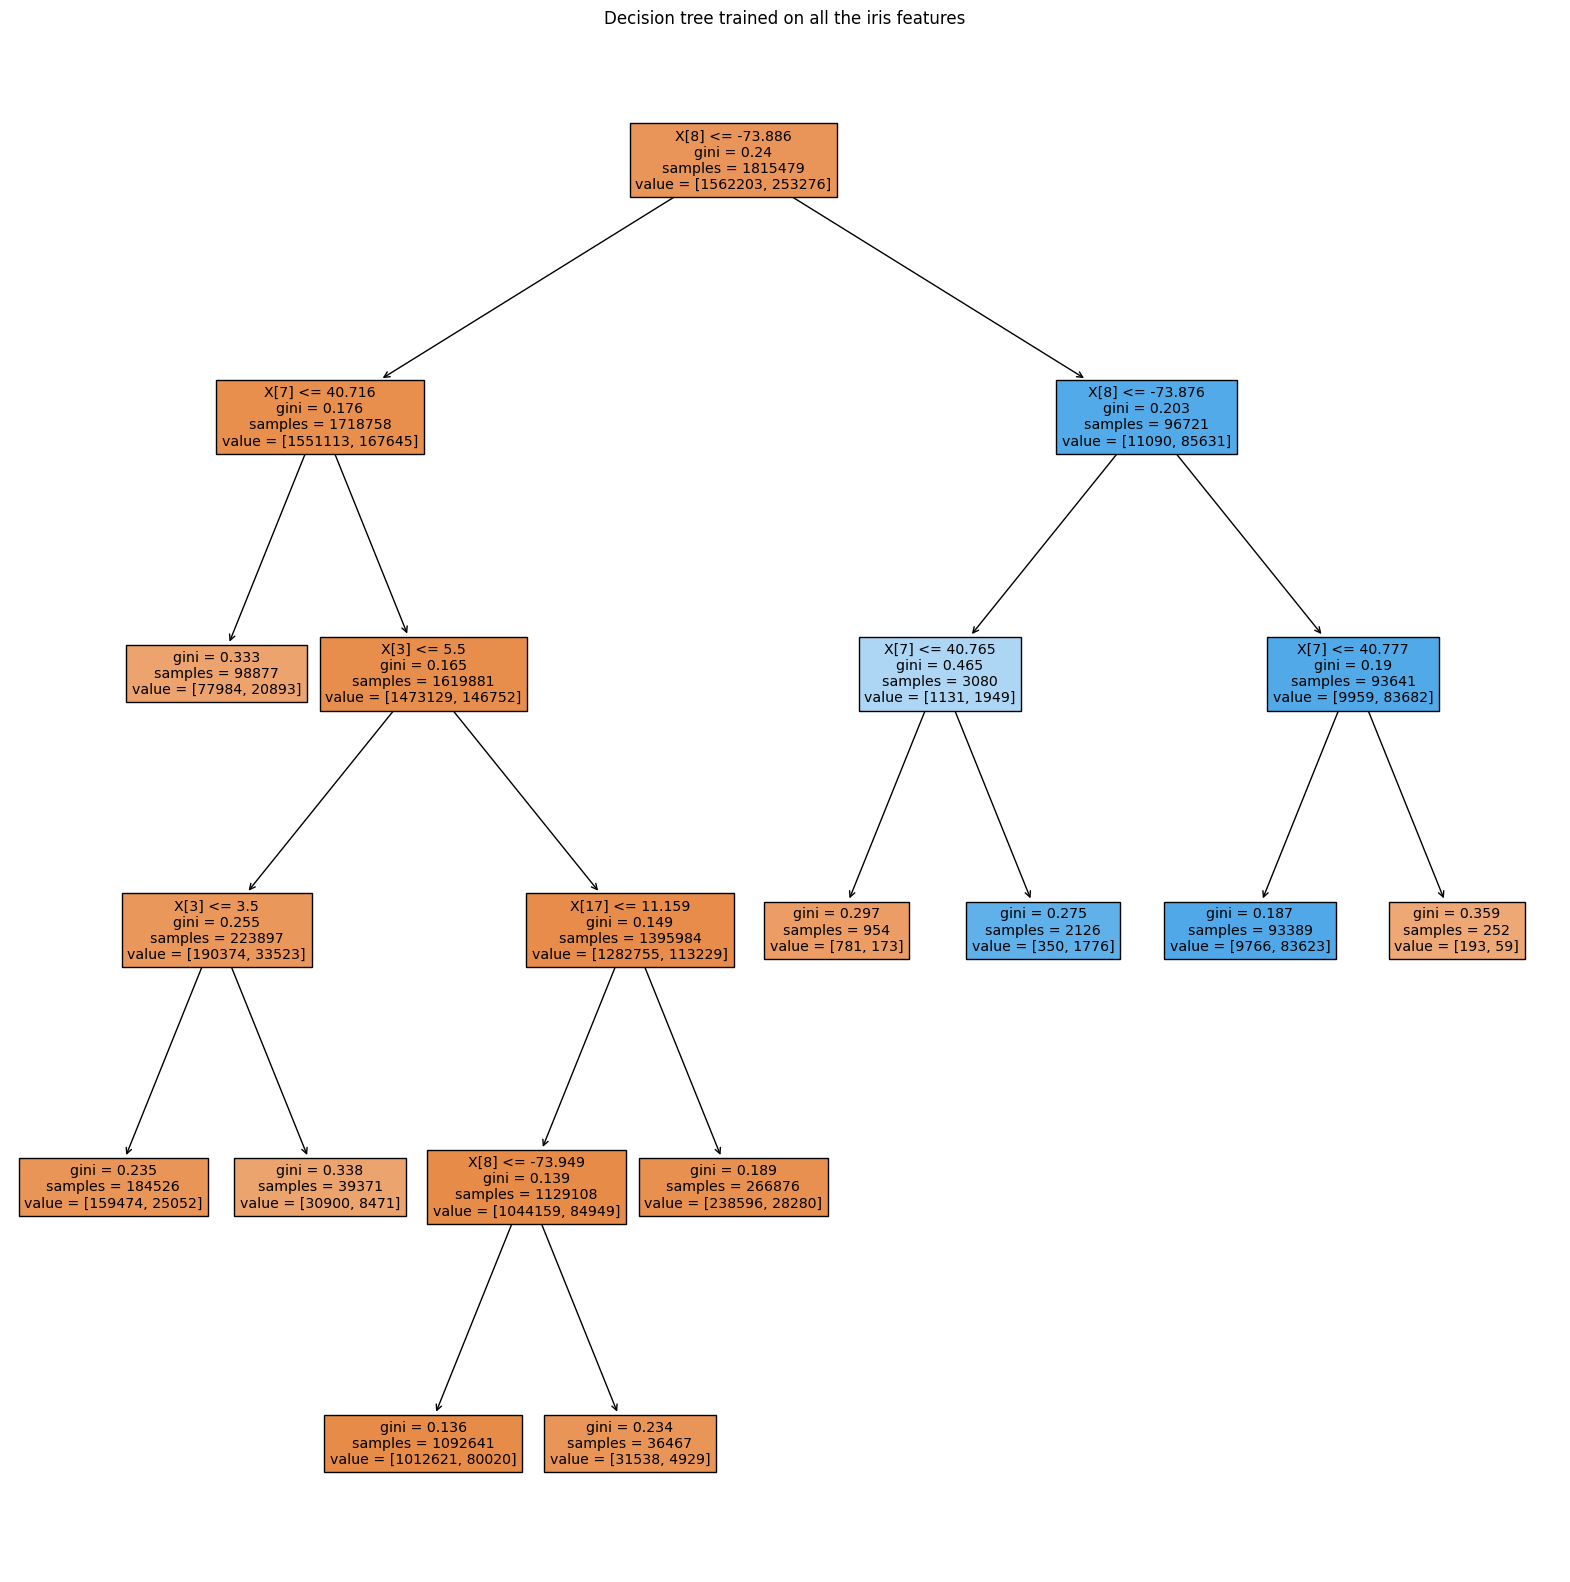

In [158]:
print(f'tree depth = {model.get_depth()}, number of leaf nodes = {model.get_n_leaves()}, params: {model.get_params()}')
print(f'feature_importance: {model.feature_importances_}')
# print name of feature with non-zero importance
important_fnames = []
for i, imp in enumerate(model.feature_importances_):
    if imp > 0:
        print(f'feature {i} {X_train.columns[i]} importance: {imp}')
        important_fnames.append(X_train.columns[i])


plt.figure(figsize=(20, 20))
plot_tree(model, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [159]:
def evaluate_model(model, xs, ys):
    y_predicted = model.predict(xs)

    accuracy = metrics.accuracy_score(ys, y_predicted)
    precision = metrics.precision_score(ys, y_predicted)
    recall = metrics.recall_score(ys,y_predicted)

    print("--------------------------------------")
    print('Accuracy is  {}'.format(accuracy))
    print('Precision is {}'.format(precision))
    print('Recall is    {}'.format(recall))
    print("--------------------------------------")
    return accuracy, precision, recall
print("The model performance for training set")
evaluate_model(model, X_train, y_train)
print("The model performance for testing set")
evaluate_model(model, X_test, y_test)

The model performance for training set
--------------------------------------
Accuracy is  0.90195810582221
Precision is 0.8940899335182956
Recall is    0.3371776244097348
--------------------------------------
The model performance for testing set
--------------------------------------
Accuracy is  0.8905050105197136
Precision is 0.8974426994906621
Recall is    0.29377029819899614
--------------------------------------


(0.8905050105197136, 0.8974426994906621, 0.29377029819899614)

In [160]:
y_predicted = model.predict(X_test)
# show percentage of different values
pd.Series(y_predicted).value_counts(normalize=True)

0    0.951551
1    0.048449
dtype: float64

## Train model with feature with non-zero importance

tree depth = 5, number of leaf nodes = 10, params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 77, 'splitter': 'best'}
feature_importance: [0.01847671 0.02904317 0.94909572 0.0033844 ]
feature 0 pickup_hour importance: 0.01847671247346801
feature 1 pickup_latitude importance: 0.029043169601665562
feature 2 pickup_longitude importance: 0.9490957188678477
feature 3 mean_fare_amount importance: 0.0033843990570186907


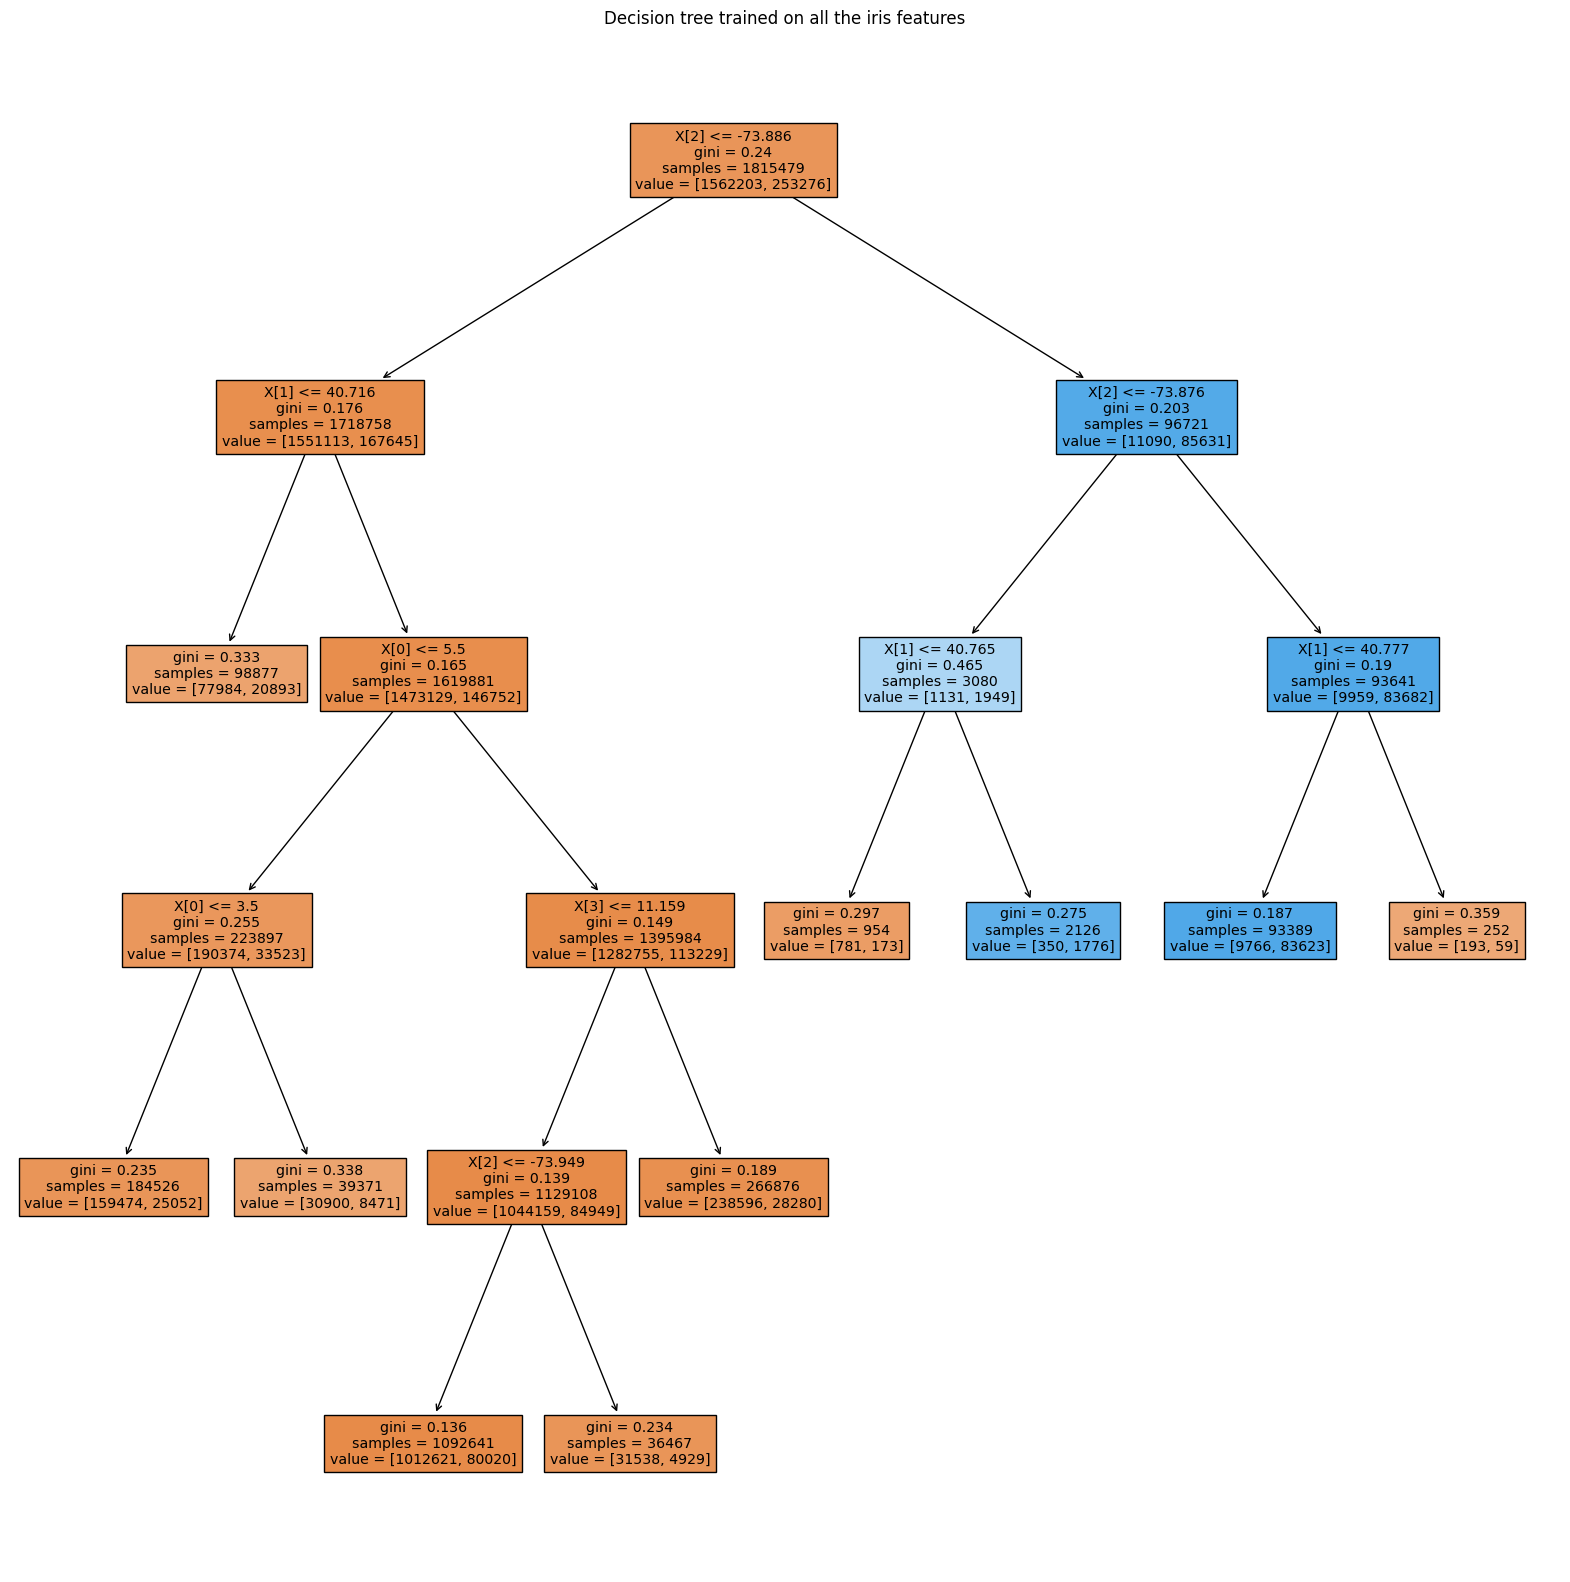

In [161]:
new_X_train = X_train[important_fnames]
new_X_test = X_test[important_fnames]

new_model = DecisionTreeClassifier(max_leaf_nodes=10, random_state=77)
new_model.fit(new_X_train, y_train)

print(f'tree depth = {new_model.get_depth()}, number of leaf nodes = {new_model.get_n_leaves()}, params: {new_model.get_params()}')
print(f'feature_importance: {new_model.feature_importances_}')
# print name of feature with non-zero importance
for i, imp in enumerate(new_model.feature_importances_):
    if imp > 0:
        print(f'feature {i} {new_X_train.columns[i]} importance: {imp}')

plt.figure(figsize=(20, 20))
plot_tree(new_model, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()

In [162]:
print("The model performance for training set")
evaluate_model(new_model, new_X_train, y_train)
print("The model performance for testing set")
evaluate_model(new_model, new_X_test, y_test)

The model performance for training set
--------------------------------------
Accuracy is  0.90195810582221
Precision is 0.8940899335182956
Recall is    0.3371776244097348
--------------------------------------
The model performance for testing set
--------------------------------------
Accuracy is  0.8905050105197136
Precision is 0.8974426994906621
Recall is    0.29377029819899614
--------------------------------------


(0.8905050105197136, 0.8974426994906621, 0.29377029819899614)